# task2：Updated情感分析

在上一小节中我们已经学习了情感分析的基本工作流程，下面我们将学习如何改进优化模型：涉及到如何使用压缩填充序列、加载和使用预训练词向量、采用不同的优化器、选择不同的RNN体系结构（包括双向RNN、多层RNN）和正则化。

本章主要内容如下：
- 序列填充
- 预训练词嵌入
- LSTM
- 双向 RNN
- 多层 RNN
- 正则化
- 优化

In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive')

## 2.1 准备数据

首先设置seed，并将其分类训练、测试、验证集。

在准备数据的时候需要注意到，由于 RNN 只能处理序列中的非 padded 元素（即非0数据），对于任何 padded 元素输出都是 0 。所以注意到我们在准备数据的时候将include_length设置为True，以获得句子的实际长度，后续需要使用。

In [ ]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.3.0/en_core_web_sm-3.3.0.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.1/671.1 KB 59.0 MB/s eta 0:00:00
  Created wheel for en-core-web-sm: filename=en_core_web_sm-3.3.0-py3-none-any.whl size=12799910 sha256=2aaaacbedb9d411f5bb1d81401dd032c2472aa7a908a8973d3912c54978c6eb4
  Stored in directory: /root/.cache/pip/wheels/3f/df/65/e2859964c23cccbe4df9d34b8f1ef96b3f9a74b3760bcb62c7
Successfully built en-core-web-sm
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.

In [ ]:
pip install torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have 

In [ ]:
!nvidia-smi

Thu Feb 23 20:41:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABEL = data.LabelField(dtype = torch.float)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

True
cuda


#### 加载 IMDb 数据集

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 23.4MB/s]


#### 从训练集中选取部分做验证集

In [ ]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

## 2.2 词向量

接下来，使用预训练词向量进行初始化操作，其中获取这些词向量是通过指定参数传递给 build_vocab 得到的。

在这里，我们选取GloVe词向量，GloVe的全称是：Global Vectors for Word Representation。[此处](https://nlp.stanford.edu/projects/glove/)有关于其有详细的介绍和大量资源。本教程将不介绍该词向量是如何具体得到的，仅简单描述下如何使用此词向量,这里我们使用的是 "glove.6B.100d" ，其中，6B表示词向量是在60亿规模的tokens上训练得到的，100d表示词向量是100维的(注意,这个词向量有800多兆)

当然也可以选择[其他的词向量](https://github.com/pytorch/text/blob/master/torchtext/vocab.py#L113)。理论上，这些预训练词向量在词嵌入向量空间中的距离在一定程度上表征了词之间的语义关系，例如，“terrible”、“awful”、“dreadful” ，它们的词嵌入向量空间的距离会非常近。

TEXT.build_vocab表示从预训练的词向量中，将当前训练数据中的词汇的词向量抽取出来，构成当前训练集的 Vocab(词汇表)。对于当前词向量语料库中没有出现的单词（记为UNK，unknown），通过高斯分布随机初始化（unk_init = torch.Tensor.normal_）。

In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:15<00:00, 26324.41it/s]


## 2.3 创建迭代器+选取GPU

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [ ]:
import os
os.chdir('/content/drive/My Drive/nlp')

In [ ]:
sen1 = ('/content/drive/My Drive/nlp/sentiment2.png')

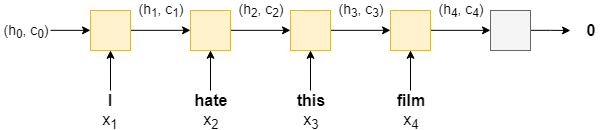

In [ ]:
from IPython.display import Image
Image(sen1)


## 2.4 构建模型


### LSTM

LSTM是标准RNN的一种变体，它增加了一种携带信息跨越多个时间步的方法，一定程度上克服了标准的RNN存在[梯度消失](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)的问题。 具体来说，LSTM加入记忆单元$c_t$，其可看作是LSTM的“内存”，存储了时刻$t$时LSTM的记忆，可以认为其中保存了从过去到时刻$t$的所有必要信息，同时使用多个门控制信息流入和流出内存，具体地看[此处](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)。 因此我们可以将LSTM看作是$x_t$、$h_t$和$c_t$的函数，而不仅仅是$x_t$和$h_t$。

$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$

因此，使用LSTM的模型结构看起来类似下面这种构造（省略了嵌入层）：



与初始隐藏状态一样，初始记忆状态$c_0$初始化为全零张量。需要注意的是，情感预测只使用最终隐藏状态，而不是最终记忆单元状态，即 $\hat{y}=f(h_T)$。


### 双向RNN


双向RNN在之前的标准RNN层上添加了一个反方向处理的RNN层。然后，拼接各个时刻的两个RNN层的隐藏状态，将其作为最后的隐藏状态向量。也就是在时间步$t$时，前向RNN处理单词$x_t$，后向RNN处理单词$x_{T-t+1}$。通过这样的双向处理，每个单词对应的隐藏状态可以从左右两个方向聚集信息，这样一来，这些向量就编码了更均衡的信息。

我们使用前向RNN的最后一个隐藏状态（从句子的最后一个单词获得）$h_T^\rightarrow$和后向RNN的最后一个隐藏状态（从句子的第一个单词获得）$h_T^\leftarrow$进行情感预测，即 $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$，下图显示了一个双向RNN，前向RNN为橙色，后向RNN为绿色，线性层为银色。

![](assets/sentiment3.png)



### 多层RNN

多层RNN（也称为深层RNN）：在初始标准RNN上多加几层RNN。第一个（底部）RNN在时间步$t$时输出的隐藏状态将是在时间步$t$时其上方RNN的输入，然后根据最终（最高）层的最终隐藏状态进行预测。
下图显示了多层单向RNN，其中层号以上标形式给出。还要注意，每个层都需要自己的初始隐藏状态，$h_0^L$。

![](assets/sentiment4.png)


### 正则化

我们已经对模型进行了各方面的改进，但是我们需要注意的是，当模型的参数逐渐增加的同时，模型过拟合的可能性就越大。为了解决这个问题，我们添加dropout正则化。Dropout的工作原理是在前向传播过程中，层中的神经元随机*Dropout*（设置为0）。每个神经元是否被drop的概率则由一个超参数设置，并不受其他神经元影响。

关于为什么dropout有效的一种理论是，参数dropout的模型可以被视为“weaker”（参数较少）的模型。因此，最终的模型可以被认为是所有这些weaker模型的集合，这些模型都没有过度参数化，因此降低了过拟合的可能性。

### Implementation Details

1.针对模型训练过程中的一点补充：在模型训练过程中，对于每个样本中补齐后加上的pad token，模型是不应该对其进行训练的，也就是并不会学习“\<pad\>”标记的嵌入。因为padding token跟句子的情感是无关的。这就意味着pad token的嵌入层(词向量)会一直保持初始化的状态（初始化为全零）。具体而言，我们是通过往nn.Embedding 层传入pad token 的index索引，作为padding_idx参数。

2.因为实验中使用的双向LSTM的包含了前向传播和后向传播过程，所以最后的隐藏状态向量包含了前向和后向的隐藏状态，所以在下一层nn.Linear层中的输入的形状就是隐藏层维度形状的两倍。
    
3.在将embeddings(词向量)输入RNN前，我们需要借助`nn.utils.rnn.packed_padded_sequence`将它们‘打包’，以此来保证RNN只会处理不是pad的token。我们得到的输出包括`packed_output` (a packed sequence)以及`hidden sate` 和 `cell state`。如果没有进行‘打包’操作，那么输出的`hidden state`和`cell state`大概率是来自句子的pad token。如果使用packed padded sentences，输出的就会是最后一个非padded元素的`hidden state` 和 `cell state`。

4.之后我们借助`nn.utils.rnn.pad_packed_sequence` 将输出的句子‘解压’转换成一个tensor张量。需要注意的是来自padding tokens的输出是零张量，通常情况下，我们只有在后续的模型中使用输出时才需要‘解压’。虽然在本案例中下不需要，这里只是为展示其步骤。

5.final hidden sate：也就是hidden，其形状是[num layers * num directions, batch size, hid dim]。因为我们只要最后的前向和后向传播的hidden states,我们只要最后2个hidden layers就行hidden[-2,:,:] 和hidden[-1,:,:]，然后将他们合并在一起,再传入线性层linear layer。 
#####这里不知道怎么解释会比较好，还需调整。


In [ ]:
v 

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        # embedding layer(word vector)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # RNN variant - Bidirectional LSTM
        self.rnn = nn.LSTM(embedding_dim,  # input_size
                           hidden_dim,  #output_size
                           num_layers=n_layers,  # Number of layers
                           bidirectional=bidirectional, #whether Bidirectional
                           dropout=dropout) #Random removal of neurons
        # Linear connection layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        # Since the forward propagation + backward propagation has two hidden sate, and is combined, multiply by 2
        
        # Random removal of neurons
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #shape of text [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #shape of embedded [sent len, batch size, emb dim]
        
        # pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #shape ofoutput[sent len, batch size, hid dim * num directions]
        #The padding tokens in the output are tensors with a value of 0
        
        #shape of hidden [num layers * num directions, batch size, hid dim]
        #shape of cell [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #shape of hidden [batch size, hid dim * num directions]
            
        return self.fc(hidden)

## 2.5 实例化模型+传入参数

为了保证pre-trained 词向量可以加载到模型中，EMBEDDING_DIM 必须等于预训练的GloVe词向量的大小。

In [ ]:
INPUT_DIM = len(TEXT.vocab) 
# 250002: Previously set to take only the 25,000 most frequent words
#plus pad_token and unknown token
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 
#Specify the parameter that defines the index value of the pad_token
#so that the model does not care about the pad token.

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

查看模型参数量

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


接下来，把前面加载好的预训练词向量复制进我们模型中的embedding嵌入层，用预训练的embeddings词向量替换掉原来模型初始化的权重参数。

我们从字段的vocab中检索嵌入，并检查它们的大小是否正确，_**[vocab size, embedding dim]**_ 

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
# Checking the shape of word vectors [vocab size, embedding dim]
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
# Replace the weight parameters initialized by the original model with the pre-trained embedding word vector
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.3485,  0.2133, -0.4966,  ..., -0.3339, -0.9237, -0.4172],
        [-0.2747, -1.0843,  0.0765,  ..., -1.1530, -0.1563, -1.2914],
        [ 0.3844, -0.7040, -0.9940,  ..., -0.1486,  2.2851,  0.9289]])

因为我们的`<unk>` 和`<pad>` token不在预训练词表里，它们已经在构建我们自己的词表时,使用 `unk_init` (an $\mathcal{N}(0,1)$ distribution)初始化了。所以，最好显式地告诉模型，将它们初始化变为0，它们与情感无关。
    
我们是通过手动设置他们的词向量权重为0的。
    
**注意**：与初始化嵌入一样，这应该在“weight.data”而不是“weight”上完成！

In [ ]:
#Set Unknown and Filler to 0
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.3485,  0.2133, -0.4966,  ..., -0.3339, -0.9237, -0.4172],
        [-0.2747, -1.0843,  0.0765,  ..., -1.1530, -0.1563, -1.2914],
        [ 0.3844, -0.7040, -0.9940,  ..., -0.1486,  2.2851,  0.9289]])


我们现在可以看到嵌入权重矩阵的前两行值都是0，需要注意的是，pad token的词向量在模型训练过程中始终不会被学习。而unknown token的词向量是会被学习的。

## 2.6 训练模型

现在开始训练模型！

我们是将随机梯度下降优化器从'SGD'更改为'Adam'。SGD使用我们设定好的学习率同步更新所有参数，而Adam会调整每个参数的学习率，给出更新频率更高的参数，以及更新频率更低的参数和更新频率不高的参数。有关“Adam”（和其他优化器）的更多信息，请参见[此处](http://ruder.io/optimizing-gradient-descent/index.html)。
 
要将'SGD'更改为'Adam'，我们只需将'optim.SGD'更改为'optim.Adam'，还要注意，我们不提供 Adam初始学习率，因为PyTorch提供了默认的初始学习率。

### 2.6.1 设置优化器

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

### 2.6.2 设置损失函数和GPU

训练模型的其它步骤保持不变。

In [ ]:
criterion = nn.BCEWithLogitsLoss() 

model = model.to(device)
criterion = criterion.to(device)

### 2.6.3 计算精确度

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

### 2.6.4 定义一个训练函数，用来训练模型

正如我们设置的“include_length=True”，我们的“batch.text”现在是一个元组，第一个元素是数字张量，第二个元素是每个序列的实际长度。在将它们传递给模型之前，我们将它们分成各自的变量“text”和“text_length”。

**注意**：因为现在使用的是dropout，我们必须记住使用`model.train（）`以确保在训练时开启 dropout。


In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad() # Gradient clearing
        
        text, text_lengths = batch.text 
# batch.text returns a tuple (a tensor of digits, the length of each sentence) 
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        # Gradient cropping to avoid gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 2.6.5 定义一个测试函数

**注意**：因为现在使用的是dropout，我们必须记住使用`model.eval（）`以确保在评估时关闭 dropout。

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text  
#batch.text returns a tuple (a tensor of digits, the length of each sentence)
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

还可以创建一个函数告诉我们epochs训练需要多长时间。

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 2.6.6 正式训练模型

Epoch: 01 | Epoch Time: 0m 28s
	Train Loss: 0.551 | Train Acc: 72.49%
	 Val. Loss: 0.579 |  Val. Acc: 71.65%
Epoch: 02 | Epoch Time: 0m 28s
	Train Loss: 0.426 | Train Acc: 81.36%
	 Val. Loss: 0.365 |  Val. Acc: 85.04%
Epoch: 03 | Epoch Time: 0m 28s
	Train Loss: 0.349 | Train Acc: 85.64%
	 Val. Loss: 0.309 |  Val. Acc: 87.72%
Epoch: 04 | Epoch Time: 0m 28s
	Train Loss: 0.314 | Train Acc: 87.41%
	 Val. Loss: 0.344 |  Val. Acc: 85.24%
Epoch: 05 | Epoch Time: 0m 28s
	Train Loss: 0.298 | Train Acc: 87.98%
	 Val. Loss: 0.280 |  Val. Acc: 88.89%


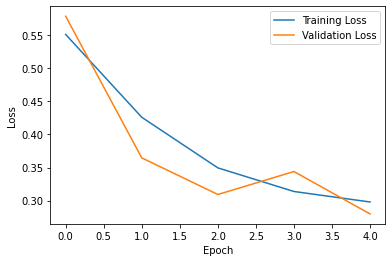

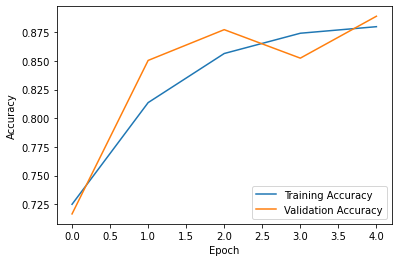

In [ ]:
import matplotlib.pyplot as plt
train_loss_history=[]
valid_loss_history=[]
train_acc_history=[]
valid_acc_history=[]
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    # Keep the model parameter with the best training result and load this later for prediction
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    # Save loss and accuracy history
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)
# Plot loss history
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2.6.7 最终测试结果

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## 2.7 模型验证

我们现在可以使用这个模型来预测我们给出的任何句子的情感了，注意需要提供的句子是电影评论方面的。

当使用模型进行实际预测时，模型要始终在evaluation mode评估模式。
    
“predict_sentiment”函数的作用如下：

- 将模型切换为evaluate模式
- 对句子进行分词操作
- 将分词后的每个词，对应着词汇表，转换成对应的index索引，
- 获取句子的长度
- 将indexes，从list转化成tensor
- 通过unsqueezing 添加一个batch维度
- 将length转化成张量tensor
- 用sigmoid函数将预测值压缩到0-1之间
- 用item（）方法，将只有一个值的张量tensor转化成整数

负面评论返回接近0的值，正面评论返回接近1的值。

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    # return prediction.item()
    if prediction >= 0.75:
      print(prediction.item(),"This sentence represents a strong positive emotion.")
    elif 0.55 < prediction and prediction < 0.75:
      print(prediction.item(),"This sentence represents a weak postive emotion.")
    elif 0.45<= prediction and prediction <= 0.55:
      print(prediction.item(),"This sentence represents a neutral emotion.")
    elif 0.25 < prediction and prediction < 0.45:
      print(prediction.item(),"This sentence represents a weak negative emotion.")
    elif 0 < prediction and prediction <= 0.25:
      print(prediction.item(),"This sentence represents a strong negative emotion.")

负面评论的例子：

In [ ]:
predict_sentiment(model, "This film is terrible")

正面评论的例子：

In [ ]:
predict_sentiment(model, "This film is great")

## 小结
我们现在已经为电影评论建立了一个情感分析模型。在下一小节中，我们将实现一个模型，这个模型会以更少的参数获得更高的精度、更快的训练速度。


